In [3]:
%matplotlib inline
#%load_ext autoreload
#%autoreload 2
%reload_ext autoreload
import numpy as np
import matplotlib.pyplot as plt
import math, sys, os
from numpy.random import randn
from sklearn.datasets import make_blobs

# setup pyspark for IPython_notebooks
spark_home = os.environ.get('SPARK_HOME', None)
sys.path.insert(0, spark_home + "/python")
sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.6.0
      /_/

Using Python version 2.7.10 (default, Jul 13 2015 12:05:58)
SparkContext available as sc, HiveContext available as sqlContext.


In [77]:
data_home = os.environ.get('DATA_HOME', None)
sys.path.insert(0, data_home)

# data
from gen_data import make_blobs_rdd

# utilitiy functions for this notebook
from lsh_util import *

# make some data
N = 1000
d = 2
k = 5
sigma = 3
bound = 10

data_RDD = make_blobs_rdd(N, d, k, sigma, bound, sc)
data_RDD.take(2)

[(4, array([-0.00991882, -1.33618685])),
 (4, array([-0.45096271, -1.1418839 ]))]

# Random projection LSH

In [78]:
def config_random_projection(d, n_hyperplanes = 5, scale = 2.0, seed = None):    
    # random projection vectors
    Z = (np.random.rand(d, n_hyperplanes) - 0.5) * scale
    def projection_func(tup):
        y, x = tup # expect key (int, 1xD vector)
        projs = x.T.dot(Z) # random projections
        bucket = to_bucket(projs)
        return (bucket, y)
    
    return (Z,projection_func)

In [79]:
Z, hash_func = config_random_projection(d)

gini_impurities = data_RDD.map(hash_func).map(to_dict).reduceByKey(reduce_count_clusters).map(gini_impurity).collect()
for b, g, c in sorted(gini_impurities):
    print "bucket: %s , in bucket: %d , gini_impurity: %f" % (b, c, g)

bucket: 4 , in bucket: 39 , gini_impurity: 0.632479
bucket: 10 , in bucket: 99 , gini_impurity: 0.480563
bucket: 11 , in bucket: 235 , gini_impurity: 0.503794
bucket: 12 , in bucket: 8 , gini_impurity: 0.000000
bucket: 14 , in bucket: 108 , gini_impurity: 0.245370
bucket: 17 , in bucket: 27 , gini_impurity: 0.400549
bucket: 19 , in bucket: 2 , gini_impurity: 0.000000
bucket: 20 , in bucket: 342 , gini_impurity: 0.515988
bucket: 21 , in bucket: 34 , gini_impurity: 0.290657
bucket: 27 , in bucket: 106 , gini_impurity: 0.018690


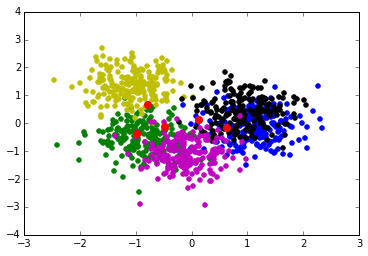

In [80]:
c0 = np.stack(data_RDD.filter(lambda t: t[0] == 0).map(lambda t: t[1]).collect())
c1 = np.stack(data_RDD.filter(lambda t: t[0] == 1).map(lambda t: t[1]).collect())
c2 = np.stack(data_RDD.filter(lambda t: t[0] == 2).map(lambda t: t[1]).collect())
c3 = np.stack(data_RDD.filter(lambda t: t[0] == 3).map(lambda t: t[1]).collect())
c4 = np.stack(data_RDD.filter(lambda t: t[0] == 4).map(lambda t: t[1]).collect())

plt.scatter(c0[:,0],c0[:,1],color='g')
plt.scatter(c1[:,0],c1[:,1],color='y')
plt.scatter(c2[:,0],c2[:,1],color='b')
plt.scatter(c3[:,0],c3[:,1],color='k')
plt.scatter(c4[:,0],c4[:,1],color='m')

# projection vectors
plt.scatter(Z.T[:,0],Z.T[:,1],color='r',s=50)

In [82]:
# impurity as we scale up the number of hyperplanes used for projections

for n_Z in range(10,201,10):
    Z, hash_func = config_random_projection(d, n_Z)
    gini_impurities = data_RDD.map(hash_func).map(to_dict).reduceByKey(reduce_count_clusters).map(gini_impurity).collect()
    g_i = weighted_gini(gini_impurities)
    print "%d projections, gini_impurity: %f" % (n_Z, g_i)
    

10 projections, gini_impurity: 0.323927
20 projections, gini_impurity: 0.320727
30 projections, gini_impurity: 0.308666
40 projections, gini_impurity: 0.288594
50 projections, gini_impurity: 0.291495
60 projections, gini_impurity: 0.280579
70 projections, gini_impurity: 0.279023
80 projections, gini_impurity: 0.279276
90 projections, gini_impurity: 0.273450
100 projections, gini_impurity: 0.261169
110 projections, gini_impurity: 0.256947
120 projections, gini_impurity: 0.252413
130 projections, gini_impurity: 0.250071
140 projections, gini_impurity: 0.241604
150 projections, gini_impurity: 0.226363
160 projections, gini_impurity: 0.235258
170 projections, gini_impurity: 0.235970
180 projections, gini_impurity: 0.235551
190 projections, gini_impurity: 0.219793
200 projections, gini_impurity: 0.227680
